## Import, Clean, Select and/or Create Data

- Import libraries, define helper functions
- If selected, either:
    - Read TeleMetrum or TeleMega data, in which case also:
        - Remove the collected data for which the rocket was either:
            - on the pad and not started motor burn
            - landed and not moving   
        - Add an approximation for velocity based on integration of the acceleration data for missing points in the TeleMega data (the TeleMega didn't start capturing velocity data until shortly before apogee)
        - Correct temperatures to what the temperature would be on the outside of the rocket by using the standard temperature lapse rate
    - Set parameters for and simulate custom flightpath

In [57]:
# Select Data
dataset_choice = 'custom' # options: telemetrum, telemega, custom

In [58]:
# import libraries, define natural constants, helper functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

R_universal = 8.3144598 # J/(mol*K)
R_specific_air = 287.058 # J/(kg*K)
MM_air = 0.0289644 # kg/mol
F_gravity = 9.80665 # m/s^2
T_lapse_rate = 0.0065 # K/m

def temp_at_height(h, temp_at_launchpad):
    return temp_at_launchpad - (h*T_lapse_rate)

def pressure_at_height(h, temp_at_launchpad):
    return 1000*87*(pow((1-(h*T_lapse_rate/(temp_at_launchpad+273.15))),(F_gravity*MM_air/(R_universal*T_lapse_rate)))) 
    # Pressure at the launch site was around 87 kPa for Prometheus' launch

def air_density_fn(pressure, temp):
    return pressure/(R_specific_air*(temp+273.15))

In [59]:
# If Prometheus dataset, import data, clean data, fix temperature, set constants, and if telemega, fix speed
if dataset_choice == 'telemetrum':
    dataset = pd.read_csv('2022-06-24-serial-5115-flight-0001.csv',skiprows=range(1,93)).iloc[:-258].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

elif dataset_choice == 'telemega':
    dataset = pd.read_csv('2022-06-24-serial-6583-flight-0003.csv',skiprows=range(1,80)).iloc[:-216].drop_duplicates().reset_index()
    dataset['time'] = dataset['time'] - dataset['time'][0]

    num_to_smooth_by = 7 # speed quite far off of TeleMetrum. Maybe try going back to acceleration based
    for i in range(num_to_smooth_by):
        dataset.at[i, 'speed'] = np.float64(0)
    for i in range(len(dataset)-num_to_smooth_by):
        if dataset['speed'][i] == '     NaN': 
            prev_points = 0
            following_points = 0
            for j in range(num_to_smooth_by):
                prev_points = prev_points + dataset['height'][i-j]
                following_points = following_points + dataset['height'][i+j]
            average_prev = prev_points/num_to_smooth_by
            average_following = following_points/num_to_smooth_by
            dataset.at[i, 'speed'] = (average_following-average_prev)/(dataset['time'][i+num_to_smooth_by]-dataset['time'][i-num_to_smooth_by])
    dataset['speed'] = pd.to_numeric(dataset['speed'])

if not dataset_choice == 'custom': 
    dataset['temperature'] = dataset['height'].apply(lambda x: temp_at_height(x,dataset['temperature'][0]))

# Define Prometheus rocket parameters
def thrust_at_time(time): 
    # as per https://www.csrocketry.com/rocket-motors/cesaroni/motors/pro-98/3g-reloads/cesaroni-m1520-blue-streak-rocket-motor.html
    if time < 0.8: return 1580 + (time)*(1785-1580)/0.8
    elif time < 2.4: return 1785
    elif time <4.5: return 1785 - (time-2.4)*(1785-1340)/2.1
    elif time <4.9: return 1340 - (time - 4.5)*(1340)/0.4
    else: return 0
def mass_at_time(time):
    if time <4.9: return 20.51-(time*(20.51-16.91)/4.9)
    else: return 16.91

A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
L_rocket = 2.229 # length of Prometheus in m
cd_rocket = 0.38 # very rough, depends on mach number, other characteristics. taken from looking at estimated Reynold's numbers and using them to read the graphs in the models generated for Prometheus' drag as a function of mach number

In [60]:
# Set custom flight parameters
if dataset_choice == 'custom':
    Prometheus_model = True # set to False if simulating another rocket
    if Prometheus_model: 
        # most already set in previous cell
        temp_at_launchpad = 34 # deg C, what it was at Prometheus' launch
    else:
        cd_rocket = 0.38
        A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
        L_rocket = 2.229
        temp_at_launchpad = 34 # deg C
        # def thrust_at_time(time): 
        # def mass_at_time(time):

In [61]:
# Simulate custom flight without airbrake deployment
if dataset_choice == 'custom':    
    timestep = 0.001
    
    half_A_cd_rocket = 0.5*cd_rocket*A_rocket
    
    time, height, speed = 0, 0, 0
    simulated_values = []
    
    while speed >=0:
        temperature = temp_at_height(height,temp_at_launchpad)        
        pressure = pressure_at_height(height,temp_at_launchpad)        
        F_drag = half_A_cd_rocket*air_density_fn(pressure, temperature) * (speed**2)
        acceleration = (thrust_at_time(time)-F_drag)/mass_at_time(time) - F_gravity
        speed += acceleration*timestep
        height += speed*timestep
        time += timestep

        simulated_values.append([time, height, speed, acceleration, temperature, pressure])

    data = {
    'time': [row[0] for row in simulated_values],
    'height': [row[1] for row in simulated_values],
    'speed': [row[2] for row in simulated_values],
    'acceleration': [row[3] for row in simulated_values],
    'temperature': [row[4] for row in simulated_values],
    'pressure': [row[5] for row in simulated_values]
    }

    dataset = pd.DataFrame(data)

## Ascent Overview

(we don't really care about what happends after apogee; that's when our job finishes. Well, maybe we'll want them to retract at apogee, but if it's survived to apogee, that's the main goal)

In [62]:
# Set graph units
imperial = True

             Time (s)  Height (ft)  Speed (ft/s)  Accel (ft/s^2)  G-force (g)
Max-g Force      1.90       447.55        482.48          263.75         8.20
Max Speed        4.76      2805.20       1091.62            0.23         0.01
Burnout          4.90      2955.56       1085.48          -88.41        -2.75
Apogee          29.22     13971.47          0.05          -32.18        -1.00


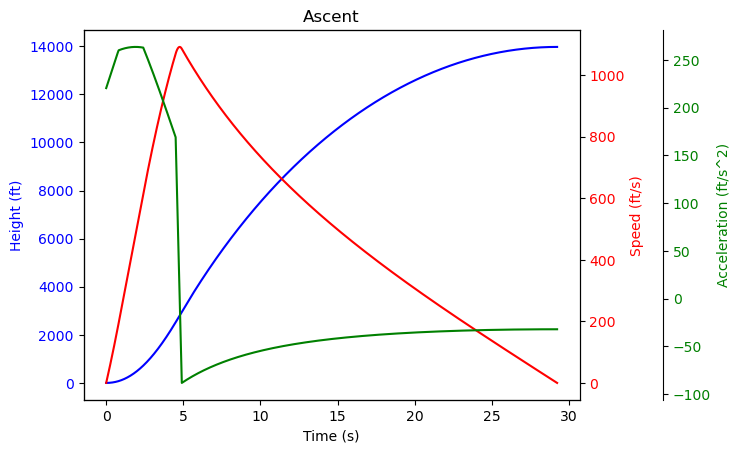

In [63]:
if dataset_choice != 'custom':
    # last 5 data points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset['height'].idxmax()-5
else:
    apogee_index = dataset['height'].idxmax()

time = dataset['time'][:apogee_index]
height = dataset['height'][:apogee_index].copy()
speed = dataset['speed'][:apogee_index].copy()
accel = dataset['acceleration'][:apogee_index].copy()

max_g_index = accel.idxmax()
max_speed_index = speed.idxmax()
if dataset_choice == 'custom':
    burnout_index = dataset['time'][dataset['time'].apply(lambda x: thrust_at_time(x) == 0)].idxmin()
else: # add consideration due to the expected drag force
    burnout_index = dataset['time'][dataset['acceleration'].apply(lambda x: x < -F_gravity)].idxmin()

unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    unit = 'ft'

parameters_at_flight_events = pd.DataFrame({
    'Time (s)': [round(time.iloc[max_g_index],2), round(time.iloc[max_speed_index],2), round(time.iloc[burnout_index],2), round(time.iloc[-1],2)],
    f'Height ({unit})': [round(height.iloc[max_g_index],2), round(height.iloc[max_speed_index],2), round(height.iloc[burnout_index],2), round(height.iloc[-1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[max_g_index],2), round(speed.iloc[max_speed_index],2), round(speed.iloc[burnout_index],2), round(speed.iloc[-1],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[max_g_index],2), round(accel.iloc[max_speed_index],2), round(accel.iloc[burnout_index],2), round(accel.iloc[-1],2)],
    f'G-force (g)': [round(dataset['acceleration'].iloc[max_g_index]/F_gravity,2), round(dataset['acceleration'].iloc[max_speed_index]/F_gravity,2), round(dataset['acceleration'].iloc[burnout_index]/F_gravity,2), round(dataset['acceleration'].iloc[-1]/F_gravity,2)],
}, 
index=['Max-g Force', 'Max Speed', 'Burnout', 'Apogee'])
print(parameters_at_flight_events)

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Dataset 1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Dataset 2')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, accel, color='g', label='Dataset 3')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.title('Ascent')
plt.show()

## Aerodynamic Forces during ascent

Max-q during ascent is:
50.552 kPa
Max reynolds number during ascent is:
3.633e+07


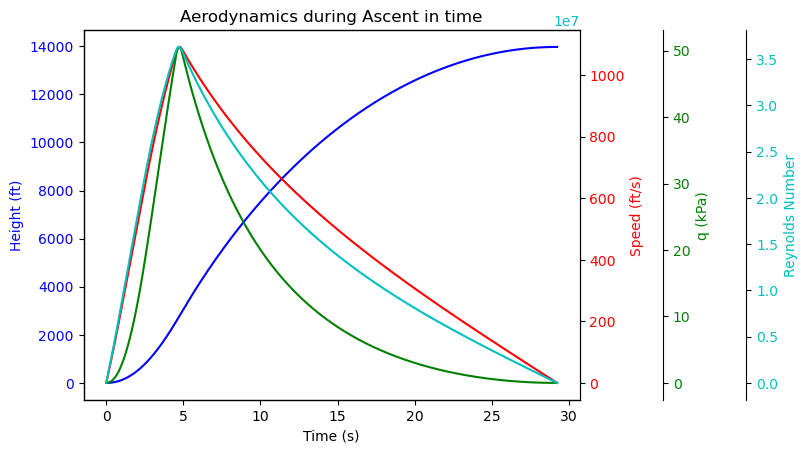

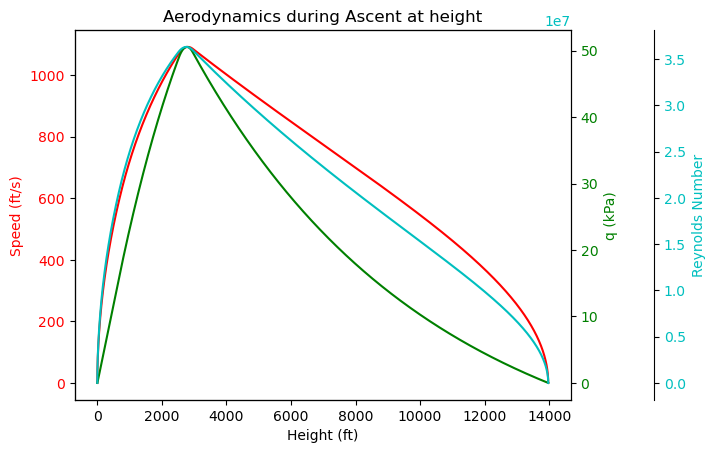

In [64]:
air_density = air_density_fn(dataset['pressure'][0:apogee_index], dataset['temperature'][0:apogee_index])
q = 0.5 * (air_density/1000) * ((dataset['speed'][0:apogee_index])**2)

len_characteristic = L_rocket

one_atm_air_dynamic_viscosity_lookup = { # https://www.me.psu.edu/cimbala/me433/Links/Table_A_9_CC_Properties_of_Air.pdf
    -150:8.636*pow(10,-6),
    -100:1.189*pow(10,-6),
    -50:1.474*pow(10,-5),
    -40:1.527*pow(10,-5),
    -30:1.579*pow(10,-5),
    -20:1.630*pow(10,-5),
    -10:1.680*pow(10,-5),
    0:1.729*pow(10,-5),
    5:1.754*pow(10,-5),
    10:1.778*pow(10,-5),
    15:1.802*pow(10,-5),
    20:1.825*pow(10,-5),
    25:1.849*pow(10,-5),
    30:1.872*pow(10,-5),
    35:1.895*pow(10,-5),
    40:1.918*pow(10,-5),
    45:1.941*pow(10,-5),
    50:1.963*pow(10,-5),
    60:2.008*pow(10,-5),
    70:2.052*pow(10,-5),
}

# Look up dynamic viscosity for two nearest temperatures and interpolate
def lookup_dynamic_viscosity(temp, one_atm_air_dynamic_viscosity_lookup):
    temp_list = list(one_atm_air_dynamic_viscosity_lookup.keys())
    if temp <= temp_list[0]:
        return one_atm_air_dynamic_viscosity_lookup[temp_list[0]]
    elif temp >= temp_list[-1]:
        return one_atm_air_dynamic_viscosity_lookup[temp_list[-1]]
    else:
        lower_temp = max([t for t in temp_list if t < temp])
        upper_temp = min([t for t in temp_list if t > temp])
        lower_viscosity = one_atm_air_dynamic_viscosity_lookup[lower_temp]
        upper_viscosity = one_atm_air_dynamic_viscosity_lookup[upper_temp]
        return lower_viscosity + (temp - lower_temp) * (upper_viscosity - lower_viscosity) / (upper_temp - lower_temp)

dynamic_viscosity = dataset['temperature'][0:apogee_index].apply(lambda x: lookup_dynamic_viscosity(x, one_atm_air_dynamic_viscosity_lookup))

reynolds_num = (air_density*dataset['speed'][0:apogee_index]*len_characteristic)/dynamic_viscosity

# note: plotting pressure against hieght of both Prometheus datasets on both ascent and descent shows them to be nearly identical. Given the significant change in speed on the way up vs the way down, this suggests that the pressure inside the av bay (which is what's read by the sensors) changes nearly instantaneously with the pressure outside, at least as far as it makes a difference for the changing rates in the max-q calculation. <- check if also consistent with other sim, note if it is

print('Max-q during ascent is:')
print('{:.3f}'.format(max(q)), 'kPa')

print('Max reynolds number during ascent is:')
print('{:.3e}'.format(max(reynolds_num)))

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Height')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Speed')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, q, color='g', label='q')
ax3.set_ylabel('q (kPa)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(time, reynolds_num, color='c', label='Reynolds Number')
ax4.set_ylabel('Reynolds Number', color='c')
ax4.tick_params(axis='y', labelcolor='c')

plt.title('Aerodynamics during Ascent in time')
plt.show()

fig2, ax1 = plt.subplots()
ax1.plot(height, speed, color='r', label='Speed')
ax1.set_xlabel(f'Height ({unit})')
ax1.set_ylabel(f'Speed ({unit}/s)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(height, q, color='g', label='q')
ax2.set_ylabel('q (kPa)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(height, reynolds_num, color='c', label='Reynolds Number')
ax3.set_ylabel('Reynolds Number', color='c')
ax3.tick_params(axis='y', labelcolor='c')

plt.title('Aerodynamics during Ascent at height')
plt.show()

## Slowing Down with Airbrakes

In [65]:
# Define airbrake parameters
num_flaps = 4
A_flap = 0.0064516 # 0.011408 is the current area in CAD, likely to decrease. 0.0064516 from Maryland's last year, which we'll probably have a similar configuration to
A_brakes = A_flap * num_flaps
cd_brakes = 1 # about what other teams had, super rough
max_deployment_speed = 10 #deg/s

In [66]:
# Define PID controller class
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.prev_error = 0
        self.integral = 0

    def calculate(self, process_variable, dt):
        error = self.setpoint - process_variable
        if error > 0:
            self.integral += error * dt
            derivative = (error - self.prev_error) / dt
            output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
            output = min(output, 45)
            output = max(output, 0)
            self.prev_error = error
        else:
            output = 45
        return output

In [67]:
# Airbrake deployment simulation

# set flightpath until airbrake deployment as identical
temp_at_launchpad = dataset['temperature'][0]
airbrake_deployment = burnout_index + 5
pre_brake_flight = dataset.head(airbrake_deployment).copy()
pre_brake_flight['deployment_angle']=0

# deploy airbrakes and see how flighpath changes. recalc everything at each timestep from moment deployed
height = pre_brake_flight['height'].iloc[-1]
deployment_height = height
speed = pre_brake_flight['speed'].iloc[-1]
time = pre_brake_flight['time'].iloc[-1]
mass = mass_at_time(pre_brake_flight['time'].iloc[-1])
timestep = 0.001
airbrake_flight = []
deployment_angle = 0

# define PID controller
Kp = 1
Ki = 0
Kd = 0.4
setpoint = (10000/3.281) - deployment_height
pid = PIDController(Kp, Ki, Kd, setpoint)

# for efficiency, may be removed when the simulation is made more accurate by the cds changing during the sim:
A_cd_brakes = A_brakes*cd_brakes
A_cd_rocket = A_rocket*cd_rocket

while speed > 0:
    time += timestep

    temperature = temp_at_height(height,temp_at_launchpad)
    pressure = pressure_at_height(height,temp_at_launchpad)
    q = 0.5 * air_density_fn(pressure, temperature) * (speed**2)

    PID_output = pid.calculate(height-deployment_height, timestep) 

    if PID_output>deployment_angle:
        deployment_angle = min(45, deployment_angle + max_deployment_speed*timestep)
    elif PID_output<deployment_angle:
        deployment_angle = max(0, deployment_angle - max_deployment_speed*timestep) 

    acceleration = -F_gravity-(np.sin(np.deg2rad(deployment_angle))*A_cd_brakes+A_cd_rocket)*q/mass
    height += speed*timestep
    speed += acceleration*timestep

    new_data = {
        'time': time,
        'height': height,
        'speed': speed,
        'temperature': temperature,
        'pressure': pressure,
        'acceleration': acceleration,
        'deployment_angle': deployment_angle
    }
    airbrake_flight.append(new_data)

ascent = pd.concat([pre_brake_flight, pd.DataFrame(airbrake_flight)], ignore_index=True)
ascent['q'] = 0.5 * air_density_fn(ascent['pressure'], ascent['temperature']) * (ascent['speed']**2)

# how high should the rocket overshoot without deployment, motor selction
# at what point during flight would we deploy?

In [68]:
# Plot new flight profile
imperial = True

Apogee without deploying airbrakes is:
13971.47 ft
Apogee with deploying airbrakes is:
9834.45 ft


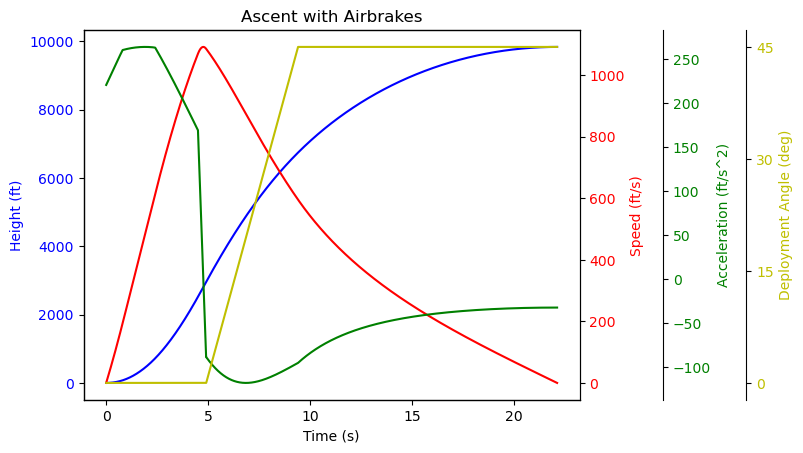

In [69]:
height = ascent['height'].copy()
speed = ascent['speed'].copy()
accel = ascent['acceleration'].copy()
apogee = ascent['height'].iloc[-1]
unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    apogee *= 3.281
    unit = 'ft'

print('Apogee without deploying airbrakes is:')
print(round(dataset['height'][apogee_index]*3.281, 2), unit)
print('Apogee with deploying airbrakes is:')
print(round(apogee,2), unit)

fig, ax1 = plt.subplots()
ax1.plot(ascent['time'], height, color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(ascent['time'], speed, color='r')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(ascent['time'], accel, color='g')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(ascent['time'], ascent['deployment_angle'], color='y')
ax4.set_ylabel(f'Deployment Angle (deg)', color='y')
ax4.tick_params(axis='y', labelcolor='y')
ax4.set_yticks(range(0, 46, 15))

plt.title('Ascent with Airbrakes')
plt.show()

Cumulative impulse due to total drag is:
3336.75 N*s
Cumulative impulse due to airbrakes drag is:
1739.20 N*s


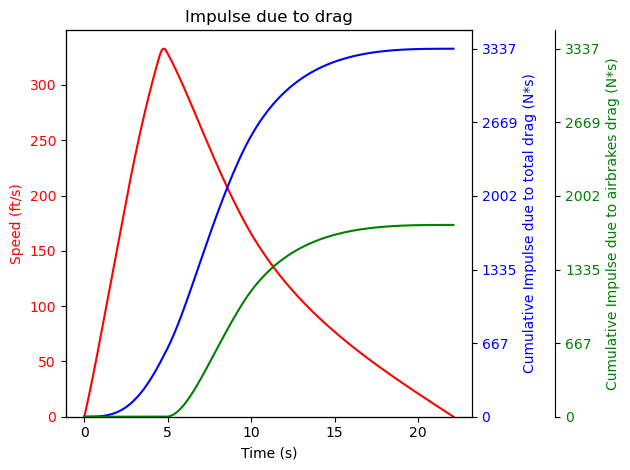

In [70]:
# impulse due to drag

impulse_due_to_total_drag = []
for i in range(len(ascent)):
    impulse_due_to_total_drag.append((ascent['q'][i]*timestep*(np.sin(np.deg2rad(ascent['deployment_angle'][i]))*A_cd_brakes+A_cd_rocket)))

cumulative_impulse_due_to_total_drag = [0]
for i in range(len(impulse_due_to_total_drag)-1): 
    cumulative_impulse_due_to_total_drag.append(cumulative_impulse_due_to_total_drag[i]+impulse_due_to_total_drag[i])
print('Cumulative impulse due to total drag is:')
print(str(cumulative_impulse_due_to_total_drag[-1])[0:7] + ' N*s')

impulse_due_to_airbrakes_drag = []
for i in range(len(ascent)):
    impulse_due_to_airbrakes_drag.append((ascent['q'][i]*timestep*np.sin(np.deg2rad(ascent['deployment_angle'][i]))*A_cd_brakes))

cumulative_impulse_due_to_airbrakes_drag = [0]
for i in range(len(impulse_due_to_airbrakes_drag)-1): 
    cumulative_impulse_due_to_airbrakes_drag.append(cumulative_impulse_due_to_airbrakes_drag[i]+impulse_due_to_airbrakes_drag[i])
print('Cumulative impulse due to airbrakes drag is:')
print(str(cumulative_impulse_due_to_airbrakes_drag[-1])[0:7] + ' N*s')


fig, ax1 = plt.subplots()
plt.title('Impulse due to drag')
# plot speed
ax1.plot(np.arange(0,len(ascent))*timestep, [ascent['speed'][i] for i in range(len(ascent))], color='r')
ax1.set_ylabel(f'Speed ({unit}/s)', color='r')
ax1.set_xlabel('Time (s)')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(bottom=0)
# plot cumulative impulse due to total drag
ax2 = ax1.twinx()
ax2.plot(np.arange(0,len(ascent))*timestep, cumulative_impulse_due_to_total_drag, color='b')
ax2.set_ylabel(f'Cumulative Impulse due to total drag (N*s)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim([0, max(cumulative_impulse_due_to_total_drag)*1.05]) # set ylim for ax2
# plot cumulative impulse due to airbrakes drag
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(np.arange(0,len(ascent))*timestep, cumulative_impulse_due_to_airbrakes_drag, color='g')
ax3.set_ylabel(f'Cumulative Impulse due to airbrakes drag (N*s)', color='g')
ax3.tick_params(axis='y', labelcolor='g')
ax3.set_ylim([0, max(cumulative_impulse_due_to_total_drag)*1.05]) # set ylim for ax3

ax2.set_yticks(np.linspace(0, max(cumulative_impulse_due_to_total_drag), 6))
ax3.set_yticks(np.linspace(0, max(cumulative_impulse_due_to_total_drag), 6))
plt.tight_layout()
plt.show()